# Statistical Tests

## Import libraries

In [1]:
#!pip install statsmodels

In [2]:
#!pip install matplotlib

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.power import tt_ind_solve_power
from scipy.stats import mannwhitneyu

## Importing data

In [4]:
df = pd.read_csv('bootstrap_homework.csv')

In [5]:
df.sample(5)

,passport_id,region,revenue,group
20341,141107359,Новосибирск,3050,0
5289,135385447,Новосибирск,4020,0
24598,140371347,Новосибирск,157,1
22237,142826448,Новосибирск,885,0
2552,134739049,Новосибирск,330,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32115 entries, 0 to 32114
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   passport_id  32115 non-null  int64 
 1   region       32115 non-null  object
 2   revenue      32115 non-null  int64 
 3   group        32115 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1003.7+ KB


In [7]:
df.isna().sum()

passport_id    0
region         0
revenue        0
group          0
dtype: int64

In [8]:
df.passport_id.nunique()

32115

In [9]:
df.group.value_counts()

1    16121
0    15994
Name: group, dtype: int64

In [10]:
df.group.value_counts(normalize=True)

1    0.501977
0    0.498023
Name: group, dtype: float64

In [11]:
df.revenue.describe()

count     32115.000000
mean       1561.262463
std        7687.990519
min         135.000000
25%         297.000000
50%         480.000000
75%        1332.000000
max      751925.000000
Name: revenue, dtype: float64

## Tasks

### Task 1.

 **Find the mean value of revenue for group 0.**

In [12]:
df[df['group'] == 0].revenue.mean()

1534.5570839064649

### Task 2.  

**Find the mean value of revenue for group 1.**

In [13]:
df[df['group'] == 1].revenue.mean()

1587.7574592146889

### Task 3.

**Calculate an absolute effect size.**

In [14]:
df[df['group'] == 1].revenue.mean() - df[df['group'] == 0].revenue.mean()

53.20037530822401

### Task 4. 

**What is the standardized effect size (Cohen D).**

In [15]:
uplift = df[df['group'] == 1].revenue.mean() - df[df['group'] == 0].revenue.mean()
sigma = df.revenue.std()

d = uplift / sigma
d

0.0069199324810495

### Task 5. 

**Calculate the sample size required to detect a 5% relative change in a two-tailed t-test with alpha = 0.05, power = 0.8. Use the data for group = 0 as the basis for calculating the necessary parameters (mean, lift, std).**

In [16]:
relative_uplift = 1.05
uplift = df[df['group'] == 0].revenue.mean() * relative_uplift - df[df['group'] == 0].revenue.mean()
sigma = df[df['group'] == 0].revenue.std()
d = uplift / sigma

sample_size = tt_ind_solve_power(effect_size = d,
                       alpha = 0.05,
                       power = 0.8,
                       ratio = 1,
                       alternative = "two-sided",
                       nobs1 = None)


print('Required sample size to detect desired relative uplift:', round(sample_size))

Required sample size to detect desired relative uplift: 162949


### Task 6. 

**Let's try to calculate the sample size using simulation to detect the same 5%, but using the Mann-Whitney U test.**

In [17]:
relative_uplift = 1.05
alpha = 0.05

sample_size_list = np.arange(800, 1600, 50)
iters = 1000
dct = dict()

data = df[df['group'] == 0].revenue

for ss in sample_size_list[:]:
    pvals = []
    for i in range(iters):
        a = np.random.choice(data, size=ss, replace=False)
        b = a * relative_uplift
        p_val = mannwhitneyu(a, b).pvalue
        pvals.append(p_val)
    effects = [x for x in pvals if x < alpha]
    power = len(effects) / len(pvals)
    dct[ss] = power

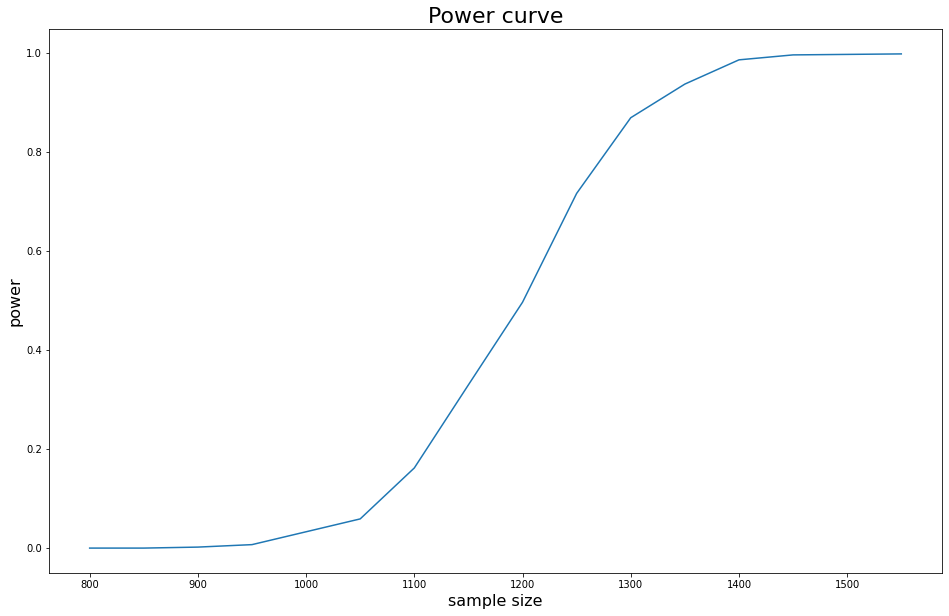

In [18]:
plt.figure(figsize=(16, 10))
plt.plot(dct.keys(), dct.values())

plt.xlabel('sample size', fontsize=16)
plt.ylabel('power', fontsize=16)
plt.title('Power curve', fontsize=22);

In [19]:
for k, v in dct.items():
    if v >= 0.8:
        print(f'Required sample size to detect desired relative uplift: {k}')
        break

Required sample size to detect desired relative uplift: 1300


### Task 7. 

**tbc...**